In [ ]:
este notebook faz o treinamento do modelo e a predição

In [ ]:
import pandas as pd
import numpy as np

import pickle

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn import model_selection, preprocessing, metrics
import plotly.express as px 
import shap

import matplotlib
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
def get_data():
    csv_name = 'dataset.csv'
    df = pd.read_csv(csv_name, index_col=[0])
    return df 

def split_data(df, initial_date, final_date):
    mask = (df['Data'] > initial_date) & (df['Data'] <= final_date)
    new_df = df.loc[mask].reset_index(drop = True)
    
    # pegando somente as colunas de features
    X = new_df.iloc[:, 1:20]
    print(X.columns)
    
    y = new_df['VOLUME DA EMISSAO']
    
    return new_df, X, y

In [79]:
df = get_data()
training_df, X_train, y_train = split_data(df, '2013-02-01', '2023-05-31')
test_df, X_test, y_test = split_data(df, '2023-05-31', '2023-09-31')

Index(['INCC', 'IPCA', 'ICC', 'ICE', 'Taxa_de_Desemprego',
       'Quantidade_de_cotas', 'Numero_de_cotistas', 'CGI', 'CDI', 'Dolar',
       'Ibovespa', 'IFIX', 'IGP-M',
       'indice_Teva_de_Fundos_Imobiliarios_de_Papel',
       'indice_Teva_de_Fundos_Imobiliarios_de_Tijolo', 'Poupança',
       'S&P_South_Africa_REIT', 'Selic', 'Taxa_Referencial'],
      dtype='object')
Index(['INCC', 'IPCA', 'ICC', 'ICE', 'Taxa_de_Desemprego',
       'Quantidade_de_cotas', 'Numero_de_cotistas', 'CGI', 'CDI', 'Dolar',
       'Ibovespa', 'IFIX', 'IGP-M',
       'indice_Teva_de_Fundos_Imobiliarios_de_Papel',
       'indice_Teva_de_Fundos_Imobiliarios_de_Tijolo', 'Poupança',
       'S&P_South_Africa_REIT', 'Selic', 'Taxa_Referencial'],
      dtype='object')


In [ ]:
train_data = lgb.Dataset(X_train, label = y_train)
valid_data = lgb.Dataset(X_test, label = y_test)

def pred(model, features):
    return model.predict(features)

In [ ]:
def cross_val(train_data, train_X, train_y):
    
    num_folds = 5
    num_round = 1000
    params = {
        "objective": "regression",
        "metric": "mse",
        "boosting_type": "gbdt",
        "num_leaves": 10,
        "learning_rate": 0.05,
        "feature_fraction": 0.67}
    
    kf = KFold(n_splits=num_folds, 
               shuffle=True, 
               random_state=42)

    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=num_round,
        nfold=num_folds,
        stratified=False,
    )
    
    best_round = len(cv_results["valid l2-mean"])

    print('model')
    model = lgb.train(params, train_data, num_boost_round=best_round)
    
    y_pred = pred(model, X_train)
    
    evals_result = {
        "y_pred" : pred(model, train_X),
        "mse" : format(mean_squared_error(train_y, y_pred), '.8f'),
        "mae" : format(mean_absolute_error(train_y, y_pred), '.8f'),
        "rmse" : format(np.sqrt(mean_squared_error(train_y, y_pred)), '.8f'),
        "r2" : format(r2_score(train_y, y_pred), '.8f')
    }

    return model, evals_result

model_crossval, evals_result_cv = cross_val(train_data, X_train, y_train)

In [69]:
evals_result_cv

{'y_pred': array([ 4.19752044e+08,  4.19752044e+08,  4.26758588e+08,  3.64842735e+08,
         3.17963489e+08,  1.22118632e+09,  9.31399081e+08,  1.68716186e+09,
         5.14842492e+09,  1.70462173e+09,  1.20372645e+09,  8.69504335e+08,
         1.48116012e+09,  1.44893239e+09,  7.96021477e+08,  6.36677725e+08,
         1.48922031e+09,  1.84628115e+08,  6.98620890e+08,  3.68240239e+09,
         5.36633898e+08,  6.83763002e+08,  1.18346226e+09,  7.76459192e+08,
         6.77265085e+08,  1.37879050e+09,  2.62753262e+08,  1.47453012e+09,
         2.85132216e+08,  3.28809975e+08,  3.34968337e+08,  7.85631901e+08,
         3.73501891e+08,  2.46191936e+08,  8.93670001e+08,  2.95596108e+08,
         6.03243942e+08,  2.84803513e+08,  3.90758056e+09,  4.58302292e+07,
        -4.89262368e+07,  1.13713770e+09,  1.00594548e+09,  1.10816472e+09,
         5.03064347e+09,  3.87279472e+08,  1.25303907e+09,  7.90797551e+08,
         2.15801318e+08,  5.50631658e+08,  5.79994588e+08,  3.53661958e+08,
  

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

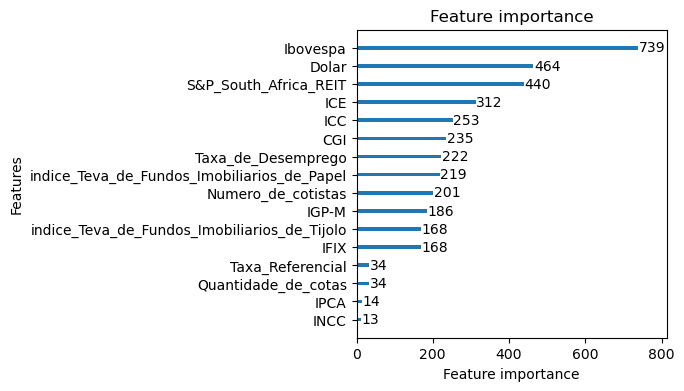

In [71]:
lgb.plot_importance(model_crossval, figsize=(4,4), grid=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


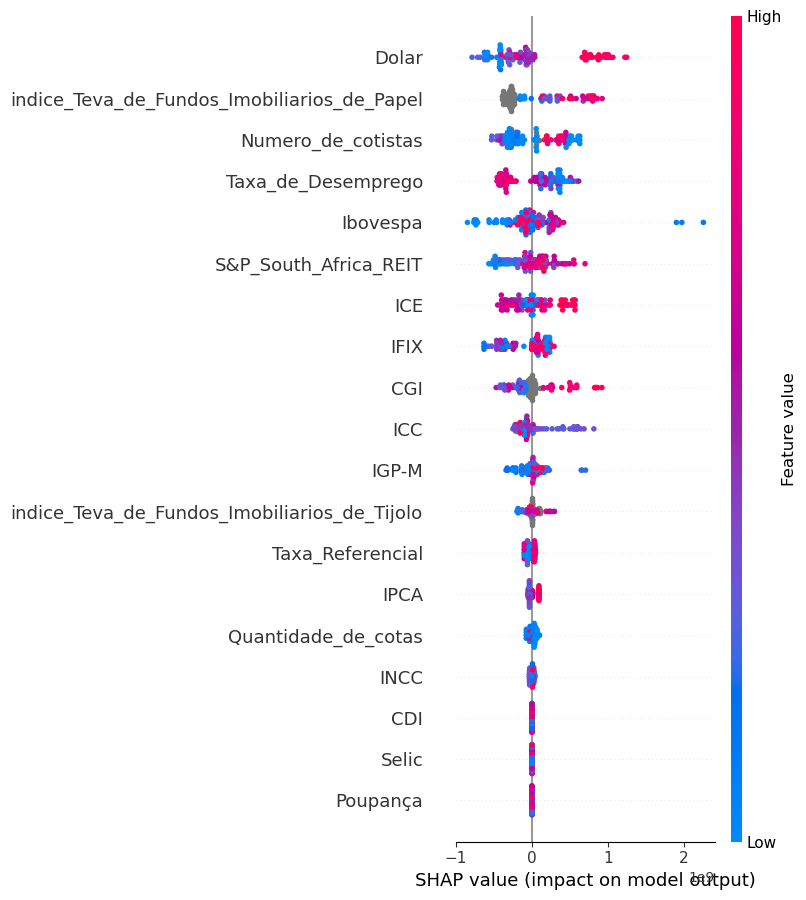

In [72]:
explainer = shap.Explainer(model_crossval)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
#shap.plots.force(explainer.expected_value, shap_values[-3], feature_names = X_train.columns)

In [102]:
training_df, X_train, y_train = split_data(df, '2013-02-01', '2023-09-31')

y_pred = model_crossval.predict(X_train)
training_df['ypred'] = y_pred
    
# Plot 
fig = px.bar(training_df, x='Data', y='VOLUME DA EMISSAO')

fig.add_scatter(x=training_df['Data'], 
                y=training_df['ypred'], name = 'model predict') # Not what is desired - need a line 

# Show plot 
fig.show()

Index(['INCC', 'IPCA', 'ICC', 'ICE', 'Taxa_de_Desemprego',
       'Quantidade_de_cotas', 'Numero_de_cotistas', 'CGI', 'CDI', 'Dolar',
       'Ibovespa', 'IFIX', 'IGP-M',
       'indice_Teva_de_Fundos_Imobiliarios_de_Papel',
       'indice_Teva_de_Fundos_Imobiliarios_de_Tijolo', 'Poupança',
       'S&P_South_Africa_REIT', 'Selic', 'Taxa_Referencial'],
      dtype='object')


In [88]:
def calc_(model, df, train_X, train_y):
    
    y_pred = model.predict(X_train)
    #df['ypred'] = ypred

    evals_result = {
            "mse" : format(mean_squared_error(train_y, y_pred), '.8f'),
            "mae" : format(mean_absolute_error(train_y, y_pred), '.8f'),
            "rmse" : format(np.sqrt(mean_squared_error(train_y, y_pred)), '.8f'),
            "r2" : format(r2_score(train_y, y_pred), '.8f')
        }
    return evals_result

evals_result_training = calc_(model_crossval,training_df, X_train, y_train)
evals_result_training

{'mse': '214169938925226432.00000000',
 'mae': '315299183.80668759',
 'rmse': '462784981.30905938',
 'r2': '0.92763957'}

In [104]:
y_pred_test = model_crossval.predict(X_test)
y_pred_test[2]

2795351351.794916

In [97]:
print(format(mean_squared_error(y_test, y_pred), '.8f'))
print(format(mean_absolute_error(y_test, y_pred), '.8f'))
print(format(np.sqrt(mean_squared_error(y_test, y_pred))), '.8f')
print(format(r2_score(y_test, y_pred), '.8f'))

6408178619177689088.00000000
1785595010.65684628
2531438053.5927973 .8f
-1.44682788


In [73]:
# #training_df['y_pred_model1'] =  y_pred
# training_df['target'] = training_df['VOLUME DA EMISSAO']
# training_df


In [ ]:

#print("Mean Squared Error:", format(mse, '.8f'))

In [63]:
#y_train